In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras

from keras import models,layers

import os
import cv2
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
warnings.filterwarnings("ignore")

In [32]:
import numpy
print("Matplotlib version:", numpy.__version__)


Matplotlib version: 1.26.4


### Loading Data / Preproceesing

In [33]:
height = 256
width = 256
batch = 8
channel = 3
epochs = 100

In [34]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('datasets/PlantVillage',image_size=(height,width),batch_size=batch,labels='inferred',label_mode='int',color_mode='rgb',shuffle=True)
file_list = tf.data.Dataset.list_files('datasets/PlantVillage/*/*.jpg')

class_name = dataset.class_names
n_classes = len(class_name)

Found 20638 files belonging to 15 classes.


In [35]:
file_list

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [36]:
# Check for batch

for img_batch,lbl_batch in dataset.take(1):
    print(img_batch[0].numpy().shape)
    print(lbl_batch.numpy())
    img_batch[0].numpy()

(256, 256, 3)
[ 0  9  0  8  9  7 12 10]


2024-08-08 14:11:24.427128: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
from IPython.display import Image

# Specify the path to your image file
image_path = "/home/elflord/Pictures/Screenshots/Screenshot from 2024-08-07 19-08-35.png"
image_path1 = "/home/elflord/Pictures/Screenshots/Screenshot from 2024-08-07 19-08-35.png"

# Display the image


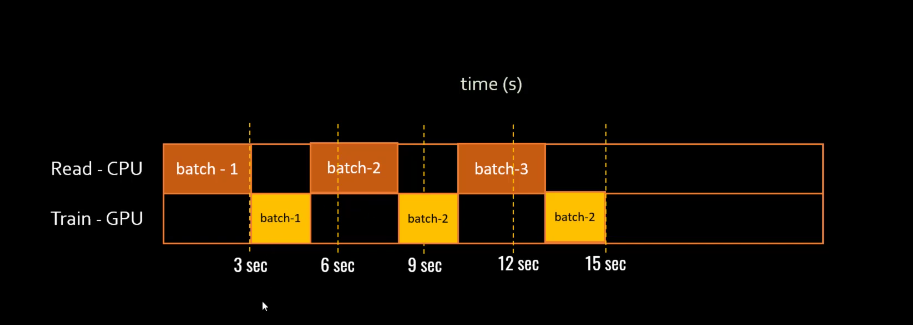

In [38]:
display(Image(filename=image_path))

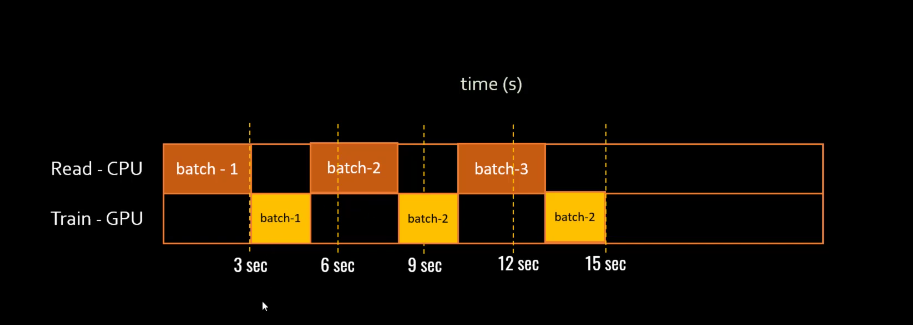

In [39]:
display(Image(filename=image_path1))

In [40]:
for img_batch, lbl_batch in dataset.take(1):
    img = img_batch[0].numpy()
    print("Image Shape:", img.shape)
    print("Image Dtype:", img.shape)

Image Shape: (256, 256, 3)
Image Dtype: (256, 256, 3)


In [41]:
# plt.figure(figsize=(15,10))
# for img_batch, lbl_batch in dataset.take(1):
#     for i in range(12):
#         ax= plt.subplot(3,4,i+1)
#         plt.imshow(img_batch[i].numpy().astype('uint8'))
#         plt.title(class_name[lbl_batch[i]])
#         plt.axis('off')

### Train Test Split /Caching and Prefetch/

In [42]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=200):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [43]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [44]:
train_ds = train_ds.cache().shuffle(200).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(200).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(200).prefetch(buffer_size = tf.data.AUTOTUNE)

In [45]:
# for images, labels in train_ds.take(1):
#     print(images.numpy().shape)
#     print(labels.numpy().shape)

# for images, labels in val_ds.take(1):
#     print(images.numpy().shape)
#     print(labels.numpy().shape)


### Rescaling and Aug Layer

In [46]:
resize_rescale = tf.keras.Sequential()
resize_rescale.add(layers.Resizing(height, width))
resize_rescale.add(layers.Rescaling(1./255))

In [47]:
data_aug = tf.keras.Sequential()
data_aug.add(layers.RandomFlip(mode="horizontal_and_vertical"))        # Randomly flip images horizontally
data_aug.add(layers.RandomRotation(factor=0.1))           # Randomly rotate images by a factor of 0.1 (10% rotation)
data_aug.add(layers.RandomZoom(height_factor=0.3, width_factor=0.3))  # Randomly zoom into images by a factor of 0.3
data_aug.add(layers.RandomTranslation(height_factor=0.2, width_factor=0.2))  # Randomly translate images
# data_aug.add(layers.RandomBrightness(factor=0.2))         # Randomly adjust brightness
# data_aug.add(layers.RandomContrast(factor=0.2))  

In [48]:
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Bulding and Training

In [49]:
# Assuming these variables are already defined: resize_rescale, batch, height, width, channel, n_classes

model = tf.keras.Sequential()

model.add(resize_rescale)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channel), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

model.build(input_shape=(batch, height, width, channel))
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (8, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (8, 256, 256, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (8, 128, 128, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (8, 128, 128, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (8, 64, 64, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (8, 64, 64, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (8, 32, 32, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (8, 32, 32, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (8, 16, 16, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (8, 8, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (8, 8, 8, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (8, 4, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (8, 4, 4, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (8, 2, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (8, 2, 2, 256)         │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (8, 1, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (8, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (8, 64)                │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (8, 15)                │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,167 (1.41 MB)

 Trainable params: 369,167 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (8, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (8, 256, 256, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (8, 128, 128, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (8, 128, 128, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (8, 64, 64, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (8, 64, 64, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (8, 32, 32, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (8, 32, 32, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (8, 16, 16, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (8, 8, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (8, 8, 8, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (8, 4, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (8, 4, 4, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (8, 2, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (8, 2, 2, 256)         │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (8, 1, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (8, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (8, 64)                │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (8, 15)                │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,167 (1.41 MB)

 Trainable params: 369,167 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, LearningRateScheduler

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Factor by which the learning rate will be reduced
    patience=10,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6          # Lower bound on the learning rate
)

# Define the LearningRateScheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1).numpy()

lr_scheduler = LearningRateScheduler(scheduler)

# Define the EarlyStopping callback with optimal parameters
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores the model weights from the epoch with the best value of the monitored quantity
)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_ds,epochs=epochs,batch_size=batch,validation_data=val_ds,callbacks=[reduce_lr, lr_scheduler, early_stopping])

Epoch 1/100
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 115s 55ms/step - accuracy: 0.2058 - loss: 2.4114 - val_accuracy: 0.2418 - val_loss: 2.2327 - learning_rate: 0.0010
Epoch 2/100
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 109s 53ms/step - accuracy: 0.3150 - loss: 2.0219 - val_accuracy: 0.4443 - val_loss: 1.6067 - learning_rate: 0.0010
Epoch 3/100
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 110s 53ms/step - accuracy: 0.4737 - loss: 1.6003 - val_accuracy: 0.5727 - val_loss: 1.2320 - learning_rate: 0.0010
Epoch 4/100
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 113s 55ms/step - accuracy: 0.5571 - loss: 1.3083 - val_accuracy: 0.5901 - val_loss: 1.2562 - learning_rate: 0.0010
Epoch 5/100
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 112s 54ms/step - accuracy: 0.6348 - loss: 1.0865 - val_accuracy: 0.6531 - val_loss: 1.0421 - learning_rate: 0.0010
Epoch 6/100
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 113s 55ms/step - accuracy: 0.6856 - loss: 0.9146 - val_accuracy: 0.7490 - val_loss: 0.7843 - learning_rate: 0.0010
Epoch 7/100
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 111s 54ms

In [52]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [53]:
history.history['loss']

[2.2827792167663574,
 1.9135640859603882,
 1.5271589756011963,
 1.260650873184204,
 1.060112714767456,
 0.8713940382003784,
 0.7404685020446777,
 0.6377406716346741,
 0.5669915676116943,
 0.5202850699424744,
 0.4356444776058197,
 0.4013536274433136,
 0.361639142036438,
 0.3279053568840027,
 0.2916026711463928,
 0.27033933997154236,
 0.24553029239177704,
 0.22272494435310364,
 0.20760811865329742,
 0.19337789714336395,
 0.17900550365447998,
 0.1616458296775818,
 0.1500849425792694,
 0.14473113417625427,
 0.13030192255973816,
 0.12577368319034576,
 0.11756712198257446,
 0.10854543000459671,
 0.11032053828239441,
 0.09687983989715576,
 0.09309367835521698,
 0.08840127289295197,
 0.0885932520031929,
 0.08397144079208374,
 0.08037843555212021,
 0.07450900971889496,
 0.075075663626194,
 0.07589792460203171,
 0.07445736229419708,
 0.06966555118560791,
 0.0652828961610794,
 0.06945574283599854,
 0.06155243143439293,
 0.057632941752672195,
 0.057824935764074326,
 0.05958636477589607,
 0.0638404

In [54]:
def plotlossacc(history):
    hist = history.history

    train_loss =hist['loss']
    val_loss=hist['val_loss']
    train_acc =hist['accuracy']
    val_acc = hist['val_accuracy']

    plt.figure(figsize=(20, 8))

    plt.figure(figsize=(20, 8))

    # Subplot 1 for Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.title('Training and Validation Loss')

    # Subplot 2 for Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.ylim(0, 1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.title('Training and Validation Accuracy')

In [55]:
scores = model.evaluate(test_ds)

258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9631 - loss: 0.1201


In [56]:
scores

[0.12642207741737366, 0.9636275172233582]

<Figure size 2000x800 with 0 Axes>

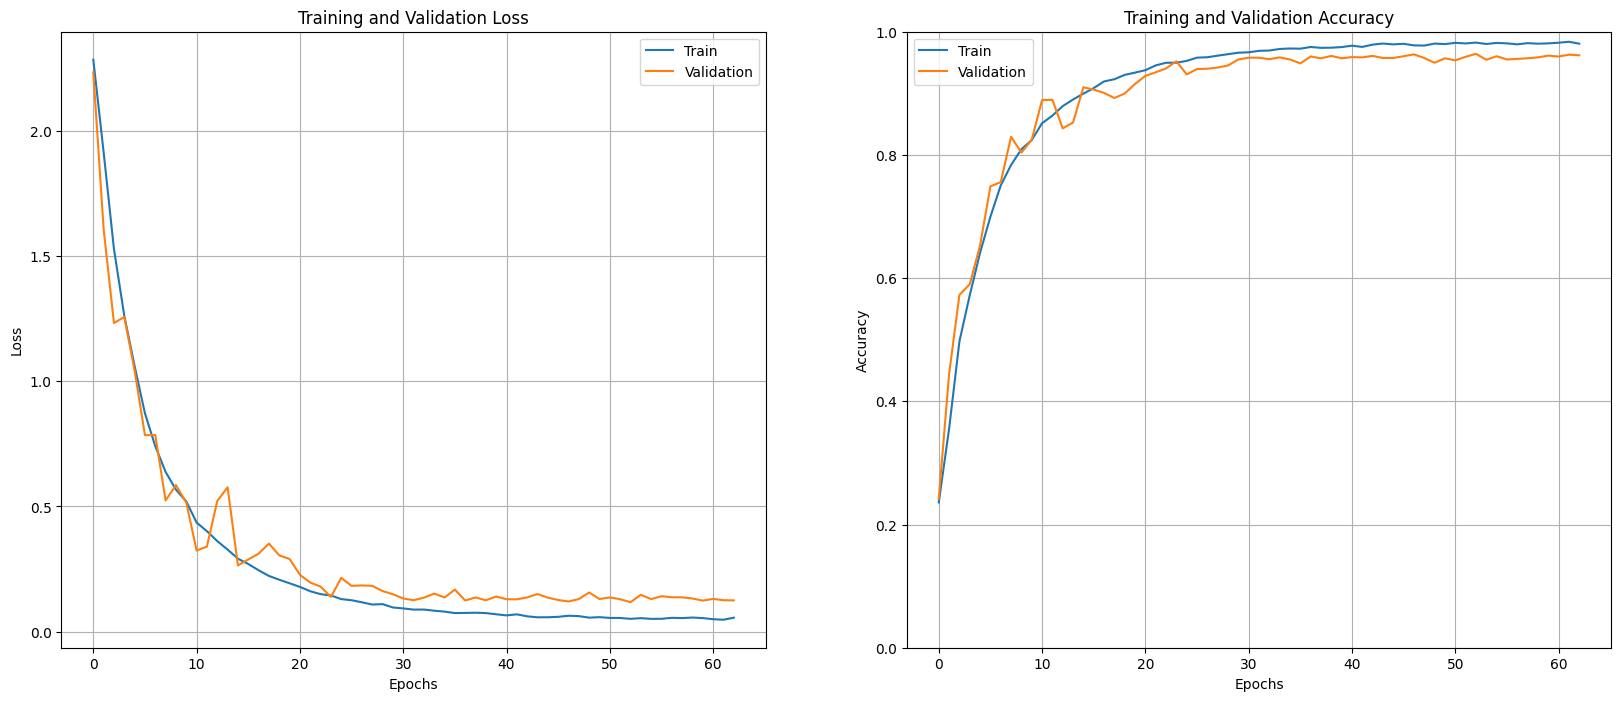

In [57]:
plotlossacc(history)

first image to predict
actual label: Tomato_Leaf_Mold
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
predicted label: Tomato_Leaf_Mold


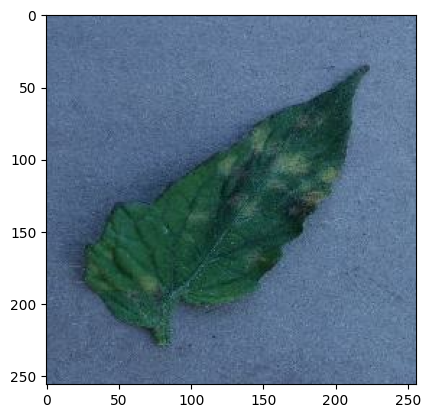

In [58]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [59]:
def predict(model, img):
    # Convert the image to an array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Add a batch dimension
    img_array = tf.expand_dims(img_array, 0)

    # Predict the class
    predictions = model.predict(img_array)

    # Get the predicted class and confidence
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


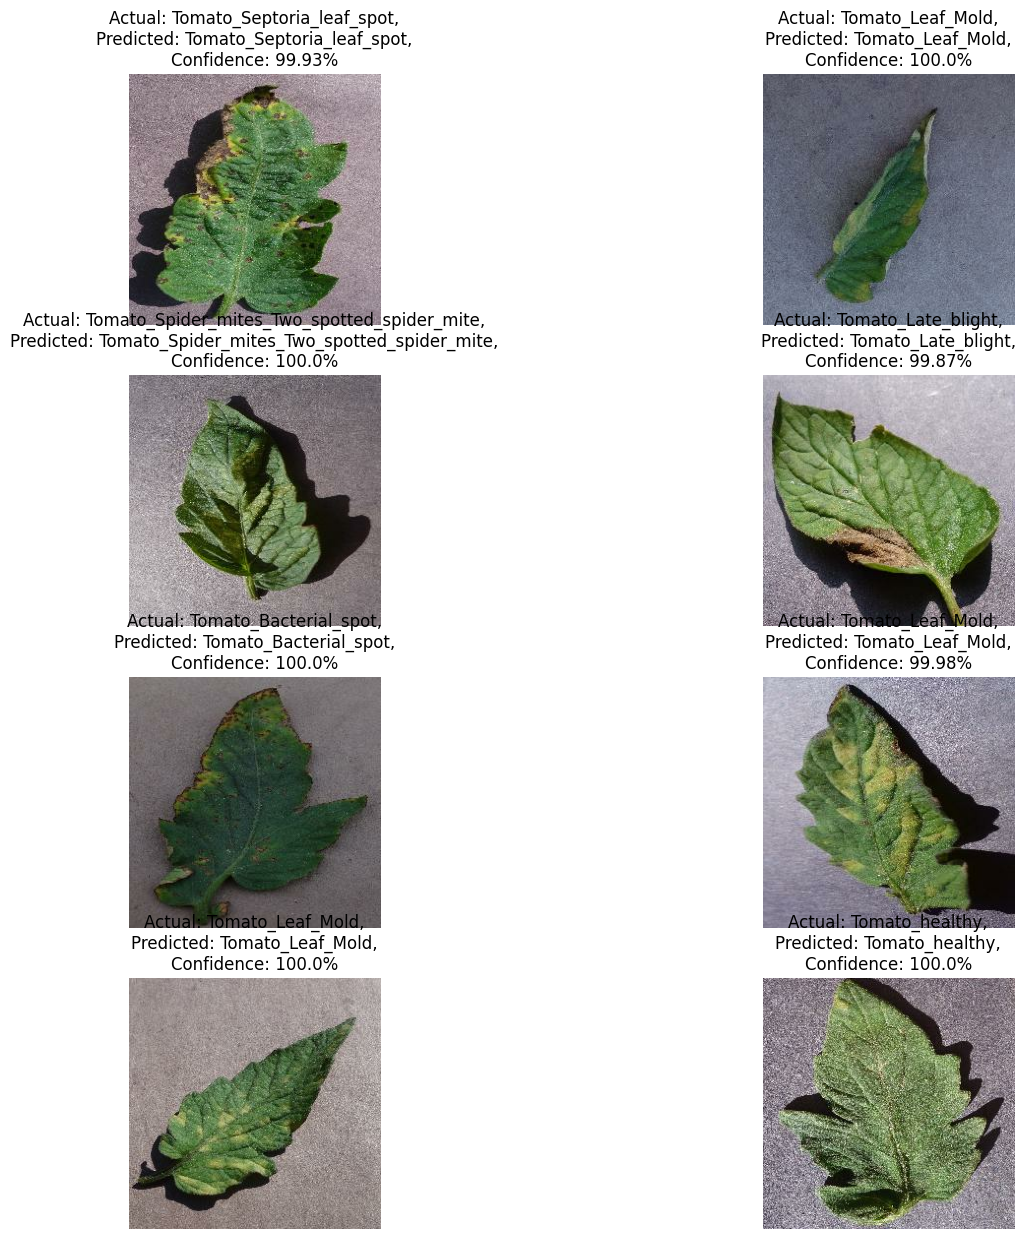

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(4, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Get the predicted and actual class
        predicted_class, confidence = predict(model, images[i].numpy().astype('uint8'))
        actual_class = class_name[labels[i]] 
        
        # Set the title with actual, predicted class and confidence
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        
        # Remove axis
        plt.axis("off")
plt.show()

In [61]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")

The current working directory is: /home/elflord/ml/tf_gpu


In [62]:
[int(i) for i in os.listdir('Models/PlantVillSD')+[0]]

[1, 0]

In [64]:
import os

# Determine the new model version
model_version = max([int(i) for i in os.listdir('Models/PlantVillSD') if i.isdigit()] + [0]) + 1
model_dir = f'Models/PlantVillSD/{model_version}'

# Create the directory if it does not exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model in HDF5 format
h5_path = os.path.join(model_dir, f'model_{model_version}.h5')
model.save(h5_path)
print(f"Model saved in HDF5 format at {h5_path}")


Model saved in HDF5 format at Models/PlantVillSD/3/model_3.h5
